In [442]:
import requests
import json
from time import sleep
import time
from bs4 import BeautifulSoup
from pathlib import Path
import numpy as np
import datetime
import os
import re
import glob
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
import pandas as pd
import re
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

now = str(datetime.datetime.now().year)+str('0'+str(datetime.datetime.now().month))[-2:]+str('0'+str(datetime.datetime.now().day))[-2:]


In [443]:
dataset = pd.read_csv('datasets/20250623_dataset_raw.csv')
dataset.drop(['singleurl'], axis=1, inplace=True)
dataset = dataset[dataset['price'] <= 20000]
dataset = dataset[dataset['stock_type'] != 'new']

In [444]:
dataset.shape

(30202, 26)

In [445]:
# remove empty/duplicate rows

cols_to_check = ['make', 'model', 'price']
dataset_cleaned = dataset[~dataset[cols_to_check].applymap(lambda x: pd.isna(x) or str(x).strip() == '').any(axis=1)]

dataset_cleaned = dataset_cleaned.drop_duplicates()

dataset_cleaned.shape

(30201, 26)

In [446]:
dataset_cleaned.describe(include='all')

make          year   trim  model stock_type fuel_type bodystyle  \
count    30201  30201.000000  29981  30201      30201     30201     30082   
unique       8           NaN    609    194          1         3        10   
top     nissan           NaN     sv   cr_v       used  Gasoline       suv   
freq      8583           NaN   2644   1881      30201     29387     13823   
mean       NaN   2015.893547    NaN    NaN        NaN       NaN       NaN   
std        NaN      4.571814    NaN    NaN        NaN       NaN       NaN   
min        NaN   1976.000000    NaN    NaN        NaN       NaN       NaN   
25%        NaN   2013.000000    NaN    NaN        NaN       NaN       NaN   
50%        NaN   2016.000000    NaN    NaN        NaN       NaN       NaN   
75%        NaN   2019.000000    NaN    NaN        NaN       NaN       NaN   
max        NaN   2025.000000    NaN    NaN        NaN       NaN       NaN   

         photo_count exterior_color interior_color         drivetrain  \
count   30201.000000          30201          30197              30201   
unique           NaN           1272            463                 10   
top              NaN          Black          Black  Front-wheel Drive   
freq             NaN           1606           9925              15573   
mean       25.715473            NaN            NaN                NaN   
std        13.518641            NaN            NaN                NaN   
min         0.000000            NaN            NaN                NaN   
25%        18.000000            NaN            NaN                NaN   
50%        27.000000            NaN            NaN                NaN   
75%        33.000000            NaN            NaN                NaN   
max        99.000000            NaN            NaN                NaN   

       transmission                                             engine  \
count         30201                                              30201   
unique          249                                               1198   
top       Automatic  2.5L I-4 DOHC, variable valve control, regular...   
freq          15796                                               1785   
mean            NaN                                                NaN   
std             NaN                                                NaN   
min             NaN                                                NaN   
25%             NaN                                                NaN   
50%             NaN                                                NaN   
75%             NaN                                                NaN   
max             NaN                                                NaN   

       mileage                     accidents_or_damage clean_title  \
count    30201                                   29802        9882   
unique   27021                                       2           2   
top      1 mi.  At least 1 accident or damage reported         Yes   
freq        33                                   15025        8751   
mean       NaN                                     NaN         NaN   
std        NaN                                     NaN         NaN   
min        NaN                                     NaN         NaN   
25%        NaN                                     NaN         NaN   
50%        NaN                                     NaN         NaN   
75%        NaN                                     NaN         NaN   
max        NaN                                     NaN         NaN   

       one_owner_vehicle personal_use_only                      open_recall  \
count              29783             29802                             4449   
unique                 2                 2                                1   
top                   No               Yes  At least 1 open recall reported   
freq               19629             21446                             4449   
mean                 NaN               NaN                              NaN   
std 

In [447]:
dataset_cleaned['year'] = dataset_cleaned['year'].astype(int)

In [448]:
dataset_cleaned['drivetrain'].unique()

array(['Front-wheel Drive', 'All-wheel Drive', 'Four-wheel Drive',
       'Rear-wheel Drive', '–', '4WD', 'FWD', 'AWD', 'Unknown',
       'Front Wheel Drive'], dtype=object)

In [449]:
for j in dataset_cleaned.columns:
    print(j+' '+str(sum(pd.isna(dataset_cleaned[j]))))

make 0
year 0
trim 220
model 0
stock_type 0
fuel_type 0
bodystyle 119
photo_count 0
exterior_color 0
interior_color 4
drivetrain 0
transmission 0
engine 0
mileage 0
accidents_or_damage 399
clean_title 20319
one_owner_vehicle 418
personal_use_only 399
open_recall 25752
comfort_rating 266
interior_rating 266
performance_rating 266
value_rating 266
exterior_rating 266
reliability_rating 266
price 0


In [450]:
# Clean up drivetrain

dataset_cleaned['drivetrain'].replace('All-wheel Drive', 'AWD', inplace=True)
dataset_cleaned['drivetrain'].replace('Front-wheel Drive', 'FWD', inplace=True)
dataset_cleaned['drivetrain'].replace('Front Wheel Drive', 'FWD', inplace=True)
dataset_cleaned['drivetrain'].replace('Rear-wheel Drive', 'RWD', inplace=True)
dataset_cleaned['drivetrain'].replace('Four-wheel Drive', '4WD', inplace=True)
dataset_cleaned['drivetrain'].replace('–', 'Unknown', inplace=True)


In [451]:
# Set to unknown instead of NaN

dataset_cleaned['interior_color'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['exterior_color'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['bodystyle'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['fuel_type'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['trim'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['clean_title'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['one_owner_vehicle'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['personal_use_only'].replace(np.nan, 'Unknown', inplace=True)
dataset_cleaned['accidents_or_damage'].replace(np.nan, 'Unknown', inplace=True)

In [452]:
# Set to none instead of NaN

dataset_cleaned['open_recall'].replace(np.nan, 'None', inplace=True)

In [453]:
# Fill out ratings by looking up same model, if still NA, use mean

isna_index = dataset_cleaned.index[pd.isna(dataset_cleaned['comfort_rating'])]

mean_comfort_rating = np.nanmedian(dataset_cleaned['comfort_rating'])
mean_interior_rating = np.nanmedian(dataset_cleaned['interior_rating'])
mean_performance_rating = np.nanmedian(dataset_cleaned['performance_rating'])
mean_value_rating = np.nanmedian(dataset_cleaned['value_rating'])
mean_exterior_rating = np.nanmedian(dataset_cleaned['exterior_rating'])
mean_reliability_rating = np.nanmedian(dataset_cleaned['reliability_rating'])

ratings_mean = {'comfort_rating' : mean_comfort_rating,
                'interior_rating' : mean_interior_rating,
                'performance_rating' : mean_performance_rating,
                'value_rating' : mean_value_rating,
                'exterior_rating' : mean_exterior_rating,
                'reliability_rating' : mean_reliability_rating}

for i in isna_index:
    make_r = dataset_cleaned.loc[i, 'make']
    model_r = dataset_cleaned.loc[i, 'model']
    year_r = dataset_cleaned.loc[i, 'year']
    
    rating_cols = [
    'comfort_rating',
    'interior_rating',
    'performance_rating',
    'value_rating',
    'exterior_rating',
    'reliability_rating'
    ]
    
    ratings_mode = {}

    for col in rating_cols:
        values = dataset_cleaned[
            (dataset_cleaned['make'] == make_r) &
            (dataset_cleaned['model'] == model_r) &
            (dataset_cleaned['year'] == year_r)
        ][col]

        if not values.mode().empty:
            ratings_mode[col] = values.mode().iloc[0]
        else:
            ratings_mode[col] = ratings_mean[col]

    # print(ratings_mode)
    
    dataset_cleaned.loc[i, 'comfort_rating'] = ratings_mode['comfort_rating']
    dataset_cleaned.loc[i, 'interior_rating'] = ratings_mode['interior_rating']
    dataset_cleaned.loc[i, 'performance_rating'] = ratings_mode['performance_rating']
    dataset_cleaned.loc[i, 'value_rating'] = ratings_mode['value_rating']
    dataset_cleaned.loc[i, 'exterior_rating'] = ratings_mode['exterior_rating']
    dataset_cleaned.loc[i, 'reliability_rating'] = ratings_mode['reliability_rating']



In [454]:
for j in dataset_cleaned.columns:
    print(j+' '+str(sum(pd.isna(dataset_cleaned[j]))))

make 0
year 0
trim 0
model 0
stock_type 0
fuel_type 0
bodystyle 0
photo_count 0
exterior_color 0
interior_color 0
drivetrain 0
transmission 0
engine 0
mileage 0
accidents_or_damage 0
clean_title 0
one_owner_vehicle 0
personal_use_only 0
open_recall 0
comfort_rating 0
interior_rating 0
performance_rating 0
value_rating 0
exterior_rating 0
reliability_rating 0
price 0


In [455]:
# Clean up the dataset, i.e. 
# 
# - remove empty rows
# - define grouping so that categorical variables has a reasonable number of categories.
# - extract number from numerical variables, e.g. 11,500 mi ---> 11500
# - identify boolean variables

In [456]:
# dataset_cleaned = pd.read_csv('datasets/20250617_dataset_raw.csv')

In [457]:
## Grouping for interior colors (interior_color -> interior_color_tone)

colors = dataset_cleaned['interior_color'].unique()

group_keywords = {
    "Neutral": ["almond", "beige", "coquina", "ivory", "cream", "macadamia", "tan", "taupe", "white", "sand", "pebble", "warm ivory"],
    "Black": ["black", "ash", "charcoal", "graphite", "obsidian", "jet", "carbon", "satin"],
    "Gray": ["gray", "grey", "stone", "platinum", "pewter", "misty", "titanium", "quartz", "meteor", "slate", "steel", "gry"],
    "Blue": ["blue", "moonstone"],
    "Red_Warm": ["red", "burgundy", "chestnut", "saddle", "cinnamon", "truffle", "camel", "java", "gold", "bisque"],
    "Brown_Earth": ["brown", "mocha", "espresso", "oak"],
}

grouped = defaultdict(list)

def assign_group(color_name):
    color_lower = color_name.lower()
    for group, keywords in group_keywords.items():
        for keyword in keywords:
            if re.search(rf"\b{re.escape(keyword)}\b", color_lower):
                return group
    return "Other"

for color in colors:
    print(color)
    group = assign_group(color)
    grouped[group].append(color)

for group, items in grouped.items():
    print(f"\n{group} ({len(items)} colors):")
    print(", ".join(sorted(items)))

Black
Gray
Charcoal
–
GREY
Misty Gray
Bisque
B-593m
BLACK
Black/Ash 2-Tone
Cashmere
Beige
Dark Stone
Graphite
Other
Ash
DARK CHARCOAL
Slate Black
Warm Ivory
Almond
Moonstone
FB12
Black Tricot
Black/Red
Steel Gray
GRAY
Ivory
Quartz
Sport
Taupe
Carbon Black
Sport Interior
Black with Orange Stitching
Titanium Gray
Gray / Steel
Off Black
Steel
Grey Cloth
Gray w/Orange Stitching
Black w/Orange Stitching
Light Gray
Black / Red
Black/Black
grey
Truffle Seat Trim
Wheat
Black/Graphite
Dark Gray
Sand Beige
Platinum
Dark Charcoal
Xse
TAN
Biege
Black w/Gray Accent
Tan
Midnight
Tan Cloth
Brown
Black/Brown
Rock Creek
Ash/Black
Olive
Sand
Silk Beige
Stone
Graphite/White Stitching
Grey
Burgundy/Dark Gray
Sand/Parchment
Bk
Java
Charcoal Cloth
Truffle
Saddle Tan
Black/Parchment
Light Blue Gray
Gone
Charcoal II
Gray w/Blue Accent
Black Leather
Blue
Black/Gray
Terracotta
Dune
Black/Ivory
Graystone
Dark charcoal
Gray/Steel
meteor
Black / Navy Blue
Saddle Brown
Mid Blue Black
SV Premium
Bei/Beige
tan
Satin 

In [458]:
# Check whether every interior_color has a interior_color_tone 
df = pd.DataFrame({
    'interior_color': dataset_cleaned['interior_color'],
    'interior_color_tone': dataset_cleaned['interior_color']
})
df['interior_color_tone'] = df['interior_color_tone'].apply(assign_group)
print(df)
print(df['interior_color_tone'].unique())

                            interior_color interior_color_tone
0                                    Black               Black
1                                     Gray                Gray
2                                     Gray                Gray
3                                    Black               Black
4                                 Charcoal               Black
5                                        –               Other
6                                 Charcoal               Black
7                                     GREY                Gray
8                                    Black               Black
9                               Misty Gray                Gray
10                                  Bisque            Red_Warm
11                                Charcoal               Black
12                                Charcoal               Black
13                                   Black               Black
14                                    Gray             

In [459]:
dataset_cleaned['interior_color_tone'] = dataset_cleaned['interior_color'].apply(assign_group)

In [460]:
## Grouping for exterior colors (exterior_color -> exterior_color_tone)

color_names = dataset_cleaned['exterior_color'].unique()

group_keywords = {
    "Black": ["black", "obsidian", "noir", "phantom", "jet", "midnight", "shadow", "onyx", "tarmac", "carbon"],
    "White": ["white", "snow", "ivory", "taffeta", "blizzard", "frost", "cotton", "diamond", "pearl white", "orchid", "wind chill", "satin"],
    "Gray": ["gray", "grey", "graphite", "cement", "charcoal", "slate", "steel", "quartz", "platinum", "tungsten", "meteor", "granite"],
    "Silver": ["silver", "mica", "metallic", "chrome", "millennium", "alloy", "sparkling", "sonic"],
    "Red": ["red", "ruby", "garnet", "crimson", "burgundy", "maroon", "sangria", "fire", "scarlet", "pulse", "chili", "flame", "rouge"],
    "Blue": ["blue", "aqua", "navy", "denim", "marine", "admiral", "azure", "indigo", "sky", "ocean", "lapis", "ribbon", "eclipse"],
    "Green": ["green", "sage", "olive", "mint", "forest", "rainforest", "cypress", "khaki", "aloe", "jade"],
    "Brown": ["brown", "bronze", "mocha", "chestnut", "walnut", "espresso", "sepia", "truffle", "coffee", "java", "burnished"],
    "Orange_Yellow": ["orange", "copper", "gold", "habanero", "sunset", "sunshine", "sunlight", "lava", "fusion", "fire"],
    "Purple": ["purple", "plum", "violet", "burgundy", "wine"],
    "Pink": ["pink", "rose", "blush"],
    "Teal": ["teal", "turquoise", "cyan"],
}

grouped = defaultdict(list)

def assign_group(color_name):
    color_lower = color_name.lower()
    for group, keywords in group_keywords.items():
        for keyword in keywords:
            if re.search(rf"\b{re.escape(keyword)}\b", color_lower):
                return group
    return "Other"

for color in color_names:
    group = assign_group(color)
    grouped[group].append(color)

for group, items in grouped.items():
    print(f"\n{group} ({len(items)} colors):")
    print(", ".join(sorted(items)))



Silver (327 colors):
4Evergreen Metallic, 4Evergreen Mica, Aberdeen Green Metallic, Aegean Blue Metallic, Alabaster Silver, Alabaster Silver Metallic, Alien Pearl Metallic, Alloy Silver, Alloy Silver Metallic, Aloe Green Metallic, Alumina Jade Metallic, Amazon Green Metallic, Apex Silver Metallic, Arctic Blue Metallic, Atomic Blue Metallic, Aurora Blue Mica, Autumn Green Metallic, Baja Yellow/Silver Stone Metallic, Bali Blue Pearl Metallic, Barcelona Red Metallic, Barcelona Red Metallic - 3R3, Billet Silver, Billet Silver Met, Billet Silver Metallic, Blaze Orange Metallic, Blazing Yellow Mica, Blue Crush Metallic, Blue Eclipse Metallic, Blue Metallic, Blue Mirage Metallic, Blue Reflex Mica, Blue Ribbon Metallic, Blue Streak Metallic, Bluestone Metallic, Bold Beige Metallic, Borrego Beige Metallic, Boston Red Metallic, Brickyard Metallic, Bright Silver, Bright Silver Metallic, Brilliant Bronze Metallic, Brilliant Silver, Brilliant Silver Metallic, Bronze Metallic, Brown Metallic, Brown

In [461]:
# Check whether every exterior_color has a interior_color_tone 
df = pd.DataFrame({
    'exterior_color': dataset_cleaned['exterior_color'],
    'exterior_color_tone': dataset_cleaned['exterior_color']
})
df['exterior_color_tone'] = df['exterior_color_tone'].apply(assign_group)
print(df)
print(df['exterior_color_tone'].unique())

                                        exterior_color exterior_color_tone
0                                  Silver Sky Metallic              Silver
1                                                 Gray                Gray
2                              Magnetite Gray Metallic                Gray
3                                                  Red                 Red
4                                     Brilliant Silver              Silver
5                                                    –               Other
6                                      Moonlight White               White
7                                 Crystal Black Silica               Black
8                                     Ruby Flare Pearl                 Red
9                               Barcelona Red Metallic              Silver
10                              Magnetic Gray Metallic                Gray
11                               Caspian Blue Metallic              Silver
12                       

In [462]:
dataset_cleaned['exterior_color_tone'] = dataset_cleaned['exterior_color'].apply(assign_group)

In [463]:
transmission_types = dataset_cleaned['transmission'].unique()

group_keywords = {
    "Manual": ["manual", "m/t", "m/t", "5-speed manual", "6-speed manual", "mt"],
    "Automatic": ["automatic", "a/t", "auto", "shiftronic", "sportmatic", "ect-i", "overdrive", "auto-shift", "sportmode", "sequential"],
    "CVT": ["cvt", "continuously variable", "lineartronic", "ecvt", "cvt transmission", "cvti-s", "cvt with sportronic"],
    "Dual Clutch": ["dual clutch", "dct", "ecoshift dual clutch"],
    "Variable": ["variable", "continuously variable transmission", "e-cvt"],
}

grouped = defaultdict(list)

def assign_group(trans_type):
    trans_lower = trans_type.lower()
    if 'not specified' in trans_lower or trans_lower.strip() == '–':
        return "Not Specified"
    for group, keywords in group_keywords.items():
        for keyword in keywords:
            if keyword in trans_lower:
                return group
    return "Other"

for trans in transmission_types:
    group = assign_group(trans)
    grouped[group].append(trans)

for group, items in grouped.items():
    print(f"\n{group} ({len(items)} items):")
    print(", ".join(sorted(items)))



Automatic (150 items):
1-Speed Automatic, 1-Speed CVT with Overdrive, 1-Speed Direct-Drive Automatic, 10-Speed Automatic, 3 Speed Automatic, 4 Spd Automatic, 4 Speed Automatic, 4 Speed with overdrive Automatic, 4 speed Automatic, 4 speed automatic, 4-Speed A/T, 4-Speed Automatic, 4-Speed Automatic with Overdrive, 4-Speed Automatic with Sportronic, 4-Speed Automatic with Sportshift, 4-Speed Shiftable Automatic, 4-speed automatic, 5 Spd Automatic, 5 Speed Automatic, 5 speed automatic, 5-Speed A/T, 5-Speed Automatic, 5-Speed Automatic Electronic Sport, 5-Speed Automatic Electronic with Overdrive, 5-Speed Automatic with Overdrive, 5-Speed Automatic with Shiftronic, 5-Speed Automatic with Tow-Haul Mode, 5-Speed Shiftable Automatic, 5-speed automatic, 6 SPD AUTO, 6 Spd Automatic, 6 Speed Automatic, 6-SPEED AUTOMATIC, 6-Speed A/T, 6-Speed Automatic, 6-Speed Automatic ECT-i, 6-Speed Automatic Electronic, 6-Speed Automatic Electronic with Overdrive, 6-Speed Automatic Sport, 6-Speed Automatic w

In [464]:
# Check whether every transmission has a transmission_type 
df = pd.DataFrame({
    'transmission': dataset_cleaned['transmission'],
    'transmission_type': dataset_cleaned['transmission']
})
df['transmission_type'] = df['transmission'].apply(assign_group)
print(df)
print(df['transmission_type'].unique())

                                            transmission transmission_type
0                                       Automatic, 6-Spd         Automatic
1                                      Automatic 6-Speed         Automatic
2                                          Automatic CVT         Automatic
3                                                    CVT               CVT
4                                              Automatic         Automatic
5                                              Automatic         Automatic
6                                                    CVT               CVT
7                                              Automatic         Automatic
8                                              Automatic         Automatic
9                                          Automatic CVT         Automatic
10                                             Automatic         Automatic
11                                             Automatic         Automatic
12                       

In [465]:
dataset_cleaned['transmission_type'] = dataset_cleaned['transmission'].apply(assign_group)

In [466]:
# Extract numbers from mileage, replace NA by mean

dataset_cleaned['mileage_clean'] = dataset_cleaned['mileage'].str.replace(',', '').str.extract(r'(\d+)').astype('Int64')
placeholder = 99999999
dataset_cleaned['mileage_clean'] = dataset_cleaned['mileage_clean'].fillna(placeholder)
mileage_mean = dataset_cleaned.loc[dataset_cleaned['mileage_clean'] != placeholder, 'mileage_clean'].mean()
dataset_cleaned['mileage_clean'] = dataset_cleaned['mileage_clean'].astype(float).replace(placeholder, mileage_mean)

In [467]:
dataset_cleaned.drop(['exterior_color', 'interior_color', 'transmission', 'mileage'], axis=1, inplace=True)

In [468]:
categorical_cols = dataset_cleaned.select_dtypes(include=['object', 'category']).columns
categorical_summary = dataset_cleaned[categorical_cols].describe(include='all')

continuous_cols = dataset_cleaned.select_dtypes(include=['number']).columns
continuous_summary = dataset_cleaned[continuous_cols].describe()

In [469]:
categorical_summary

make   trim  model stock_type fuel_type bodystyle drivetrain  \
count    30201  30201  30201      30201     30201     30201      30201   
unique       8    610    194          1         3        11          5   
top     nissan     sv   cr_v       used  Gasoline       suv        FWD   
freq      8583   2644   1881      30201     29387     13823      15589   

                                                   engine  \
count                                               30201   
unique                                               1198   
top     2.5L I-4 DOHC, variable valve control, regular...   
freq                                                 1785   

                           accidents_or_damage clean_title one_owner_vehicle  \
count                                    30201       30201             30201   
unique                                       3           3                 3   
top     At least 1 accident or damage reported     Unknown                No   
freq                                     15025       20319             19629   

       personal_use_only open_recall interior_color_tone exterior_color_tone  \
count              30201       30201               30201               30201   
unique                 3           2                   7                  13   
top                  Yes        None               Black              Silver   
freq               21446       25752               17739                8501   

       transmission_type  
count              30201  
unique                 7  
top            Automatic  
freq               25048

In [470]:
continuous_summary

year   photo_count  comfort_rating  interior_rating  \
count  30201.000000  30201.000000    30201.000000     30201.000000   
mean    2015.893547     25.715473        4.595295         4.531717   
std        4.571814     13.518641        0.234534         0.230655   
min     1976.000000      0.000000        2.000000         2.000000   
25%     2013.000000     18.000000        4.500000         4.400000   
50%     2016.000000     27.000000        4.600000         4.600000   
75%     2019.000000     33.000000        4.800000         4.700000   
max     2025.000000     99.000000        5.000000         5.000000   

       performance_rating  value_rating  exterior_rating  reliability_rating  \
count        30201.000000  30201.000000     30201.000000        30201.000000   
mean             4.517566      4.549008         4.636363            4.664372   
std              0.276580      0.246545         0.221002            0.234250   
min              1.000000      2.000000         2.000000            1.000000   
25%              4.400000      4.500000         4.500000            4.600000   
50%              4.600000      4.600000         4.700000            4.700000   
75%              4.700000      4.700000         4.800000            4.800000   
max              5.000000      5.000000         5.000000            5.000000   

              price  mileage_clean  
count  30201.000000   30201.000000  
mean   13662.963147  106406.083347  
std     4494.111361   49949.651970  
min        0.000000       0.000000  
25%     9998.000000   71532.000000  
50%    14275.000000  101631.000000  
75%    17500.000000  134849.000000  
max    20000.000000  580000.000000

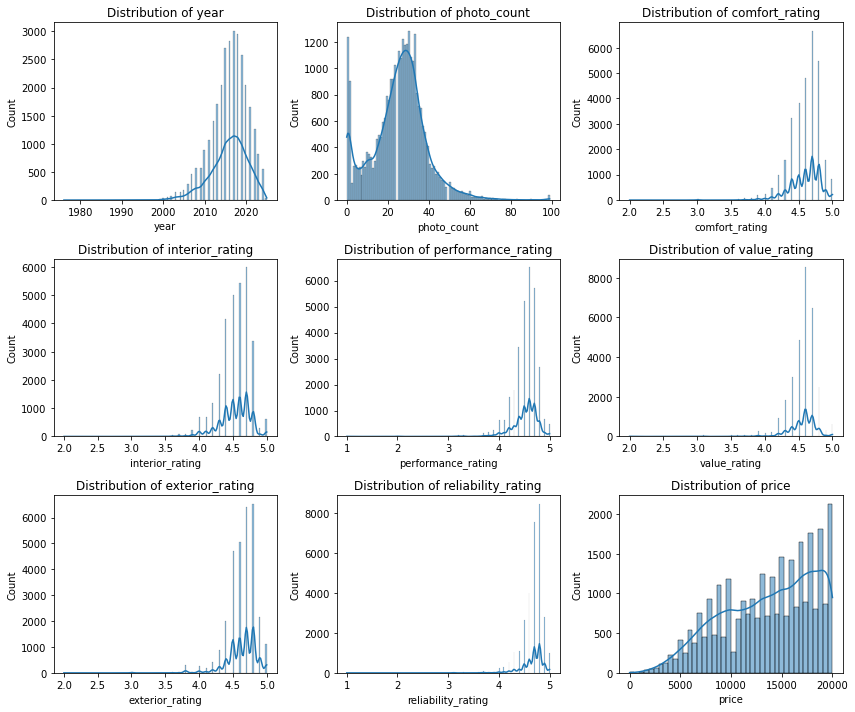

In [471]:
# Continuous variable plots

fig, axes = plt.subplots(3, 3, figsize=(12, 5 * 2))
axes = axes.flatten()

for i, col in enumerate(continuous_summary.columns[0:9]):
    sns.histplot(dataset_cleaned[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [472]:
dataset_cleaned = dataset_cleaned[[c for c in dataset_cleaned.columns if c != 'price'] + ['price']]

In [473]:
dataset_cleaned = dataset_cleaned[dataset_cleaned['transmission_type'] != 'Dual Clutch']
dataset_cleaned = dataset_cleaned[dataset_cleaned['exterior_color_tone'] != 'Pink']

In [474]:
dataset_cleaned = dataset_cleaned.sample(frac=1, random_state=998).reset_index(drop=True)

In [475]:
dataset_cleaned.to_csv('datasets/20250623_dataset_cleaned.csv', index=False)

In [476]:
dataset_cleaned.shape

(30195, 26)